In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel("/content/drive/MyDrive/pittsburgh-annotation/hate-speech-fırat-annotated.xlsx")

In [3]:
df["Hate Speech"] = df["Hate Speech"].fillna("0")

In [4]:
df["Hate Speech"].value_counts()

0      2829
1.0     123
0.0      48
Name: Hate Speech, dtype: int64

In [5]:
df['Hate Speech'] = df['Hate Speech'].astype(int)

In [6]:
df['Hate Speech'].value_counts()

0    2877
1     123
Name: Hate Speech, dtype: int64

In [7]:
df.columns

Index(['Annotator', '#_annotation', 'text', 'dis_hate_spee', 'Hate Speech'], dtype='object')

In [8]:
df.rename(columns={"Hate Speech":"label"},inplace=True)

In [ ]:
df

In [10]:
import re

def preprocess_turkish_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|https\S+', '', text)
    return text.strip()

In [11]:
df['text'] = df['text'].apply(preprocess_turkish_text)

In [12]:
df["label"].value_counts()

0    2877
1     123
Name: label, dtype: int64

# Resampling

In [13]:
from sklearn.utils import resample

In [14]:
majority_class = df[df['label'] == 0]
minority_class = df[df['label'] == 1]
minority_class_upsampled = resample(minority_class,
                                    replace=True,
                                    n_samples=len(majority_class),
                                    random_state=42)
hate_speech_balanced = pd.concat([majority_class, minority_class_upsampled])
hate_speech_balanced['label'].value_counts()

0    2877
1    2877
Name: label, dtype: int64

# Train & Val & Test Split

In [15]:
from sklearn.model_selection import train_test_split
train_val_set, test_set = train_test_split(hate_speech_balanced, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_val_set, test_size=1/8, random_state=42)
(train_set.shape[0], val_set.shape[0], test_set.shape[0])

(4027, 576, 1151)

In [16]:
train_set.to_json("/content/drive/MyDrive/pittsburgh-annotation/train.json", orient="records",lines=True)
val_set.to_json("/content/drive/MyDrive/pittsburgh-annotation/validation.json", orient="records",lines=True)
test_set.to_json("/content/drive/MyDrive/pittsburgh-annotation/test.json", orient="records",lines=True)

In [17]:
train = pd.read_json("/content/drive/MyDrive/pittsburgh-annotation/train.json", orient="records",lines=True)

In [18]:
train["label"].value_counts()

0    2014
1    2013
Name: label, dtype: int64

In [1]:
import random

In [2]:
import numpy as np

In [3]:
import torch

In [4]:
def set_seed(seed=12):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(12)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...
Epoch 1/3 - Loss: 0.45933875042253625, Precision: 0.8761018168735384, Recall: 0.8541243224932249, F1 Macro: 0.8517786561264822, MCC: 0.7298953379459626
Epoch 2/3 - Loss: 0.20615780867725433, Precision: 0.939799331103679, Recall: 0.9390969802555169, F1 Macro: 0.9391039121764944, MCC: 0.8788960307249581
Epoch 3/3 - Loss: 0.11674320799467747, Precision: 0.9609034722729153, Recall: 0.9583272841656988, F1 Macro: 0.9582051219925858, MCC: 0.9192271464864072
Best F1 Macro Score: 0.9582051219925858
Best model saved to /content/drive/MyDrive/pittsburgh-annotation/hate_speech_best_model.pth
Tokenizer saved to content/drive/MyDrive/pittsburgh-annotation/hate_speech_tokenizer


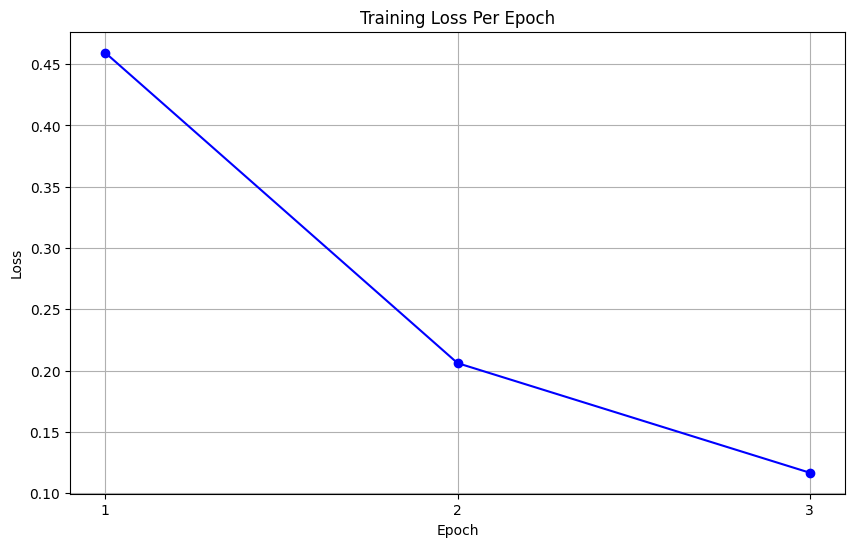

In [6]:
import torch
from collections import Counter
from sklearn.utils import resample
from transformers import BertConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer, ConvBertConfig
from torch.utils.data import DataLoader, Dataset
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef
from transformers import get_linear_schedule_with_warmup
import random
from sklearn.utils.class_weight import compute_class_weight

# Parameters
pretrained_model = "dbmdz/bert-base-turkish-128k-cased"
max_seq_length = 512
batch_size = 8
num_epochs = 3
learning_rate = 2e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleDataset(Dataset):
    def __init__(self, examples, tokenizer, max_length=max_seq_length):
        self.examples = examples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        text, label = self.examples[idx]
        text = text if isinstance(text, str) else ""
        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        return torch.tensor(encoded['input_ids']), torch.tensor(encoded['attention_mask']), torch.tensor(label)


def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = [json.loads(line) for line in file.readlines()]
    return [(line['text'], line['label']) for line in lines if line['text']]


tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
config = BertConfig.from_pretrained(pretrained_model, num_labels=1, hidden_dropout_prob=0.2, attention_probs_dropout_prob=0.2)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, config=config)
model.to(device)

train_data = load_data('/content/drive/MyDrive/pittsburgh-annotation/train.json')
test_data = load_data('/content/drive/MyDrive/pittsburgh-annotation/validation.json')

train_dataset = SimpleDataset(train_data, tokenizer)
test_dataset = SimpleDataset(test_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)  #weight_decay=1e-5, lr=2e-5
#class_weights = compute_class_weight('balanced', classes=[0, 1], y=[label for _, label in train_data])
#class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss()

epoch_losses, epoch_precisions, epoch_recalls, epoch_f1_macros, epoch_mccs = [], [], [], [], []

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_loader)*num_epochs)

best_val_loss = float('inf')
patience, patience_threshold = 0, 2
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

best_f1_macro = 0.0
best_model_state = None

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        logits = logits.squeeze(-1)

        loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()


    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)



    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.sigmoid(outputs.logits).round().view(-1)
            all_preds.extend(predictions.tolist())
            all_labels.extend(labels.view(-1).tolist())


    precision, recall, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    mcc = matthews_corrcoef(all_labels, all_preds)
    epoch_precisions.append(precision)
    epoch_recalls.append(recall)
    epoch_f1_macros.append(f1_macro)
    epoch_mccs.append(mcc)
    if epoch_f1_macros[epoch] > best_f1_macro:
        best_f1_macro = epoch_f1_macros[epoch]
        best_model_state = model.state_dict().copy()
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss}, Precision: {precision}, Recall: {recall}, F1 Macro: {f1_macro}, MCC: {mcc}")

model_save_path = '/content/drive/MyDrive/pittsburgh-annotation/hate_speech_best_model.pth'
torch.save(best_model_state, model_save_path)
print(f"Best F1 Macro Score: {best_f1_macro}")
print(f"Best model saved to {model_save_path}")

tokenizer_save_path = 'content/drive/MyDrive/pittsburgh-annotation/hate_speech_tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Tokenizer saved to {tokenizer_save_path}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o', color='blue')
plt.title("Training Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_epochs+1))
plt.grid(True)
plt.show()


In [7]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset


model_path = '/content/drive/MyDrive/pittsburgh-annotation/hate_speech_best_model.pth'
tokenizer_path = 'dbmdz/bert-base-turkish-128k-cased'
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=1)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)


df = pd.read_json("/content/drive/MyDrive/pittsburgh-annotation/test.json",orient="records",lines=True)


class CSVTextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=max_seq_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)
        return torch.tensor(encoded['input_ids']).to(device), torch.tensor(encoded['attention_mask']).to(device)

texts = df['text'].tolist()
csv_dataset = CSVTextDataset(texts, tokenizer)
csv_loader = DataLoader(csv_dataset, batch_size=batch_size)

def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for input_ids, attention_mask in data_loader:
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).squeeze()
            preds = (probs > 0.5).long().cpu().numpy()
            predictions.extend(preds)
    return predictions


predictions = predict(model, csv_loader)
df['hate_speech_label'] = predictions


output_file_path = "/content/drive/MyDrive/pittsburgh-annotation/test_predicted.json"

df.to_json(output_file_path,orient="records",lines=True)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Test Data Statistics

In [8]:
df = pd.read_json("/content/drive/MyDrive/pittsburgh-annotation/test_predicted.json",orient="records",lines=True)

In [10]:
match_percentage = (df['hate_speech_label'] == df['label']).mean() * 100
print(f"The match percentage is {match_percentage:.2f}%")

The match percentage is 96.26%


In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

df = df.dropna(subset=['hate_speech_label', 'label'])

tn, fp, fn, tp = confusion_matrix(df['label'], df['hate_speech_label']).ravel()

accuracy = accuracy_score(df['label'], df['hate_speech_label'])
precision = precision_score(df['label'], df['hate_speech_label'])
recall = recall_score(df['label'], df['hate_speech_label'])
f1 = f1_score(df['label'], df['hate_speech_label'])

print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

True Negatives: 539, False Positives: 35, False Negatives: 8, True Positives: 569
Accuracy: 0.96
Precision: 0.94
Recall: 0.99
F1 Score: 0.96


In [12]:
import pandas as pd
errors_df = df[df['label'] != df['hate_speech_label']]
for index, row in errors_df[['text', 'label', 'hate_speech_label']].head().iterrows():
    print(f"Example {index + 1}:")
    print(f"Text: {row['text']}")
    print(f"Actual Label: {row['label']}")
    print(f"Predicted Label: {row['hate_speech_label']}\n")


Example 1:
Text: Minin pkk yanlısı yarkadaş seçimden sonra görüşürüz
Actual Label: 0
Predicted Label: 1

Example 25:
Text: Terörist top Bursa
Actual Label: 1
Predicted Label: 0

Example 30:
Text: Faşistin daniskası sizlersiniz ırkçısin teröristlerle yiyip içen de senin gibiler.Daha 1000 yıl böyle gider.Siz adam olmazsiniz
Actual Label: 0
Predicted Label: 1

Example 75:
Text: HDP demek PKK demek
Actual Label: 0
Predicted Label: 1

Example 81:
Text: Terörist top Bursa
Actual Label: 1
Predicted Label: 0

